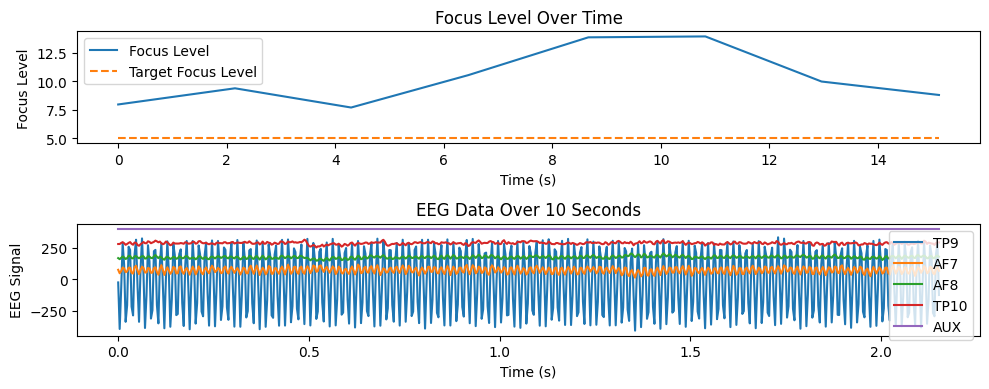

KeyboardInterrupt: 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pylsl import StreamInlet, resolve_byprop
import time
from scipy.signal import welch
from IPython.display import clear_output

# Parameters
FS = 256  # EEG sampling rate (update based on device)
CHUNK_LENGTH = 12
LSL_SCAN_TIMEOUT = 5
WINDOW_SIZE = FS * 2  # 2-second window
STEP_SIZE = FS  # 1-second step

# Frequency Bands
BANDS = {
    "theta": (4, 7),
    "alpha": (8, 13),
    "beta": (14, 30),
    "gamma": (31, 50),
    "sixty": (55, 65),
}

# Function to compute band power
def compute_band_power(data, fs, band):
    freqs, psd = welch(data, fs, nperseg=fs)
    return np.trapz(psd[(freqs >= band[0]) & (freqs <= band[1])])

# Resolve EEG stream
print("Looking for an EEG stream...")
streams = resolve_byprop('type', 'EEG', timeout=LSL_SCAN_TIMEOUT)
if not streams:
    raise RuntimeError("EEG Stream not found.")

print("Started acquiring data.")
inlet = StreamInlet(streams[0], max_chunklen=CHUNK_LENGTH)
info = inlet.info()
NCHAN = info.channel_count()
CH_NAMES = ['TP9', 'AF7', 'AF8', 'TP10', 'AUX'][:NCHAN]

# Data collection function
def collect_data(recording_time=30):
    start_time = time.time()
    all_data, all_timestamps = [], []
    while time.time() - start_time < recording_time:
        data, timestamps = inlet.pull_chunk(timeout=0.1, max_samples=CHUNK_LENGTH)
        if timestamps:
            all_data.extend(data)
            all_timestamps.extend(timestamps)
    return np.array(all_data).T, np.array(all_timestamps)

# Process EEG data
def process_data(all_data):
    band_levels = {key: [] for key in BANDS}
    for start in range(0, all_data.shape[1] - WINDOW_SIZE, STEP_SIZE):
        window_data = all_data[:, start:start + WINDOW_SIZE]
        for band_name, band_range in BANDS.items():
            band_levels[band_name].append(
                np.mean([compute_band_power(ch_data, FS, band_range) for ch_data in window_data])
            )
    return band_levels

# Compute focus index
def compute_focus_index(theta, alpha, beta):
    epsilon = 1e-6  # Avoid division by zero
    return (np.array(beta) / (np.array(alpha) + np.array(theta) + epsilon)).tolist()

# Thresholds (adjust as needed)
THRESHOLD_GAMMA = 8
THRESHOLD_SIXTY = 250

# Live Plotting
timestamps, focus_levels, target_focus_levels = [], [], []
start_time = time.time()
focus_or_not = True
while True:
    focus_or_not = not focus_or_not
    for _ in range(15):
        target_focus = 14 if focus_or_not else 5
        current_time = time.time() - start_time
        
        # Collect and process data
        new_data, new_timestamps = collect_data(2)
        band_levels = process_data(new_data)
        focus_level = np.mean(band_levels["gamma"])
        
        # Determine shared variable
        focus_val = 2 if focus_level > THRESHOLD_GAMMA * 2 else 1 if focus_level > THRESHOLD_GAMMA else 0
        print(focus_val)
        
        # Update plot data
        timestamps.append(current_time)
        focus_levels.append(focus_level)
        target_focus_levels.append(target_focus)
        
        # Clear and redraw plot
        clear_output(wait=True)
        fig, axes = plt.subplots(2, 1, figsize=(10, 4))
        
        # Focus Level Plot
        axes[0].plot(timestamps, focus_levels, label="Focus Level")
        axes[0].plot(timestamps, target_focus_levels, label="Target Focus Level", linestyle='dashed')
        axes[0].set_xlabel("Time (s)")
        axes[0].set_ylabel("Focus Level")
        axes[0].legend()
        axes[0].set_title("Focus Level Over Time")
        
        # EEG Data Plot
        for i in range(NCHAN):
            axes[1].plot(new_timestamps - new_timestamps[0], new_data[i] + i * 100, label=CH_NAMES[i])
        
        axes[1].set_xlabel("Time (s)")
        axes[1].set_ylabel("EEG Signal")
        axes[1].set_title("EEG Data Over 10 Seconds")
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()


In [ ]:
import nest_asyncio
import uvicorn
import threading
from fastapi import FastAPI
import asyncio

# Apply nest_asyncio to allow running FastAPI inside Jupyter
nest_asyncio.apply()

app = FastAPI()

# Global variable to be updated
shared_var = 0

# Async function to simulate real-time updates
async def update_var():
    global shared_var
    while True:
        await asyncio.sleep(1)  # Update every second
        #shared_var += 1

# FastAPI endpoint to return the latest value
@app.get("/latest_value")
async def get_latest_value():
    return {"shared_var": focus_val}

# Start real-time updates in the background
@app.on_event("startup")
async def startup():
    asyncio.create_task(update_var())

# Function to run FastAPI in a separate thread
def run_server():
    uvicorn.run(app, host="127.0.0.1", port=8000)

# Run the server in a separate thread so it doesn't block Jupyter
server_thread = threading.Thread(target=run_server, daemon=True)
server_thread.start()
